### 0. Dataset

The dataset has been sourced from The BRATS 2021 (Brain Tumor Segmentation) contest.
https://www.kaggle.com/datasets/dschettler8845/brats-2021-task1

Purpose: The main purpose of the dataset is to promote the development of automated methods for tumor segmentation, which is the process of identifying and delineating tumor regions in brain images.

Image Modalities: The dataset includes multimodal brain MRI (Magnetic Resonance Imaging) scans, which consist of `four` different imaging modalities: `T1-weighted`, `T1-weighted with gadolinium contrast enhancement (T1Gd)`, `T2-weighted`, and `Fluid Attenuated Inversion Recovery (FLAIR)`. Each modality provides different types of information about the brain structure and tumor characteristics.

Tumor Types: The dataset covers `four` main types of brain tumors: Glioma, Astrocytoma, Oligodendroglioma, and Glioblastoma.

- A .nii file, also known as a NIfTI file, is a common format used in neuroimaging research to store and exchange brain imaging data. 
- It stores both the image data and the associated metadata in a single file, making it more convenient to work with.
- To use .nii files in Python, you can use the `nibabel` library.

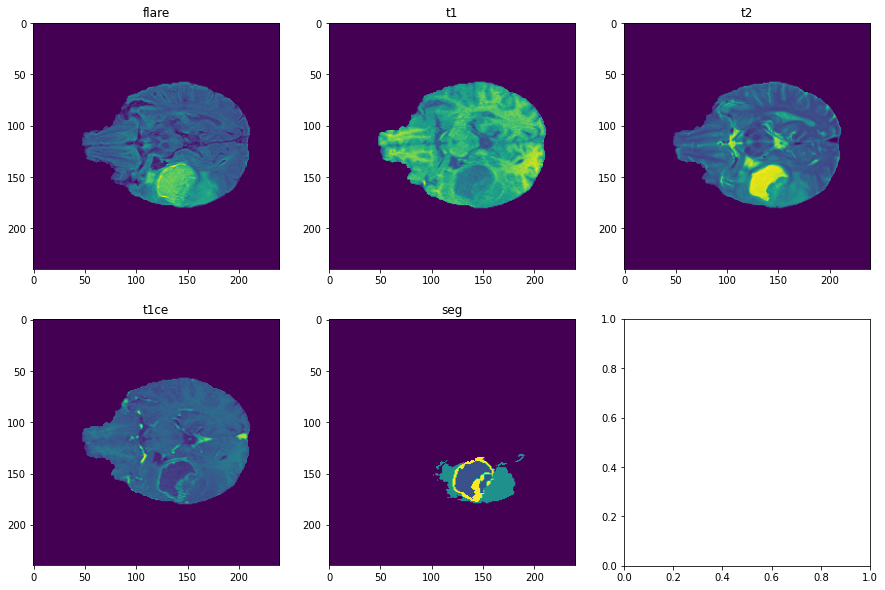

- Due to resource limit we will consider only 3 imaging variants for input(flare, t1ce, t2).
- Also t1 image variant has the least contrast around the tumor.


### 1. Pre Processing the data

- We have 4 image variants(flare, t1ce, t2, seg) for a data set.
- The first 3(flare, t1ce, t2) images will me merged into a single numpy data structure.           
(Think it of as a image having 3 channels in each pixel)
- 4th one(seg) will be used as the desired output format for the model.        
(It represents the segments of a tumor)
- Also the images will be cropped from 240x240x240 to 128x128x128 to save space and time.         
(flare + t1ce + t2) = merged.npy [shape:(128, 128, 128, 3)]

In [10]:
import glob
import numpy as np
import nibabel as nb
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical

In [ ]:
if not os.path.exists(os.path.join("processed_data")):
    os.makedirs(os.path.join("processed_data", "input"))
    os.makedirs(os.path.join("processed_data", "output"))

scaler = MinMaxScaler()
flair_files = glob.glob("BraTS2021_Training_Data/BraTS2021_*/BraTS2021_*_flair.nii.gz")
t1_files = glob.glob("BraTS2021_Training_Data/BraTS2021_*/BraTS2021_*_t1.nii.gz")
t2_files = glob.glob("BraTS2021_Training_Data/BraTS2021_*/BraTS2021_*_t2.nii.gz")
t1ce_files = glob.glob("BraTS2021_Training_Data/BraTS2021_*/BraTS2021_*_t1ce.nii.gz")
seg_files = glob.glob("BraTS2021_Training_Data/BraTS2021_*/BraTS2021_*_seg.nii.gz")

# print(len(flair_files), len(t1_files), len(t2_files), len(t1ce_files), len(seg_files))

for i in range(len(flair_files)):
    flare_data = nb.load(flair_files[i]).get_fdata()
    # t1_data = nb.load(t1_files[i]).get_fdata()
    t2_data = nb.load(t2_files[i]).get_fdata()
    t1ce_data = nb.load(t1ce_files[i]).get_fdata()
    seg_data = nb.load(seg_files[i]).get_fdata()
    
    # Converting datatype from float to int8 because it has only 4 unique values(0, 1, 2, 4)
    seg_data = seg_data.astype(np.int8)
    
    # reassigning 4 -> 3
    seg_data[seg_data==4] = 3 
    # print(np.unique(seg_data))  #(0, 1, 2, 3)

    # cropping out unecessary data
    flare_data = flare_data[40:210,40:210,:]
    # t1_data = t1_data[40:210,40:210,:]
    t2_data = t2_data[40:210,40:210,:]
    t1ce_data = t1ce_data[40:210,40:210,:]
    seg_data = seg_data[40:210,40:210,:]
    
    # Normalizing the data to range [0,1]
    flare_data = scaler.fit_transform(flare_data.reshape(-1, flare_data.shape[-1])).reshape(flare_data.shape)
    # t1_data = scaler.fit_transform(t1_data.reshape(-1, t1_data.shape[-1])).reshape(t1_data.shape)
    t2_data = scaler.fit_transform(t2_data.reshape(-1, t2_data.shape[-1])).reshape(t2_data.shape)
    t1ce_data = scaler.fit_transform(t1ce_data.reshape(-1, t1ce_data.shape[-1])).reshape(t1ce_data.shape)

    # combining all the 4 image variants into a single image
    merged = np.stack([flare_data, t1ce_data, t2_data], axis=-1)
    
    #saving the image if the mask has enough usable data
    _, counts = np.unique(seg_data, return_counts=True)
    if 1 - counts[0]/counts.sum() > 0.01:   #if useful data is atleast 1% in the given volume
        seg_data = to_categorical(seg_data, num_classes=4)
        np.savez_compressed(os.path.join("processed_data", "input", "input_"+str(i).zfill(4)+".npz"), merged)
        np.savez_compressed(os.path.join("processed_data", "output", "output_"+str(i).zfill(4)+".npz"), seg_data)
        print("Done", i)

In [ ]:
import splitfolders
input_folder = 'processed_data'
output_folder = 'split_data'
splitfolders.ratio(input_folder, output=output_folder, seed=34353, ratio=(.75, .25), group_prefix=None, move=True)
os.removedirs('processed_data')

### 2. Training

In [14]:
import tensorflow
from utility import imageLoader
from models.unet3d import simple_unet_model
import segmentation_models_3D as sm

Segmentation Models: using `tf.keras` framework.


In [17]:
train_img_dir = "split_data/train/input/"
train_mask_dir = "split_data/train/output/"

val_img_dir = "split_data/val/input/"
val_mask_dir = "split_data/val/output/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)


batch_size = 1

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)


#Define loss, metrics and optimizer to be used for training
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = tensorflow.keras.optimizers.Adam(LR)

#Fit the model 
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size



model = simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.input_shape)
print(model.output_shape)

In [ ]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=20,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

model.save('trained_model.hdf5')

### 3. Plotting accuracy and loss graphs

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

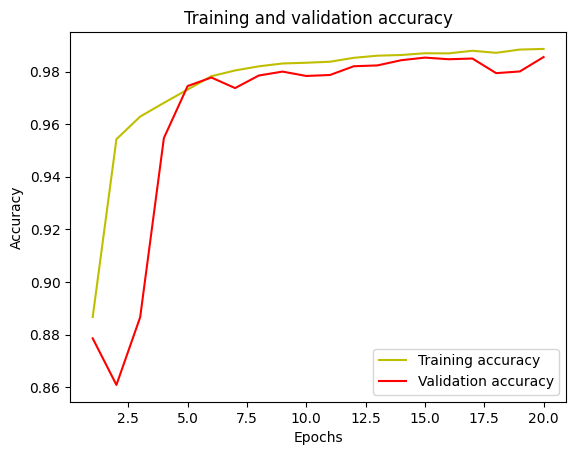
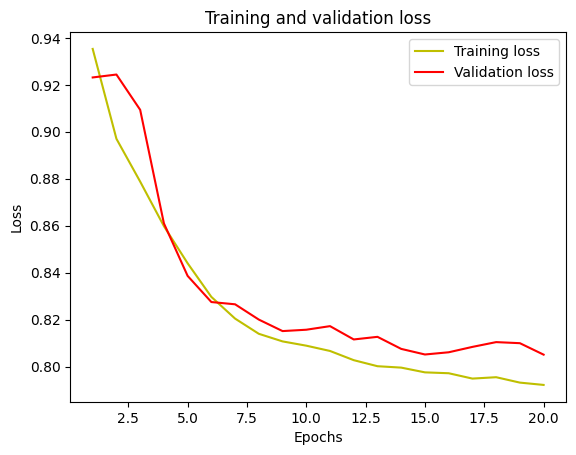

### 4. Load and further train the model (optional)

In [ ]:
from keras.models import load_model
my_model = load_model('trained_model.hdf5', 
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})

#Now all set to continue the training process. 
history2=my_model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=20,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )
my_model.save('retrained_model.hdf5')

### 5. Load the model and predict the results

In [3]:
from matplotlib import pyplot as plt
from keras.models import load_model
import random

In [25]:
my_model = load_model('unet_plusplus_3d.hdf5', 
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})

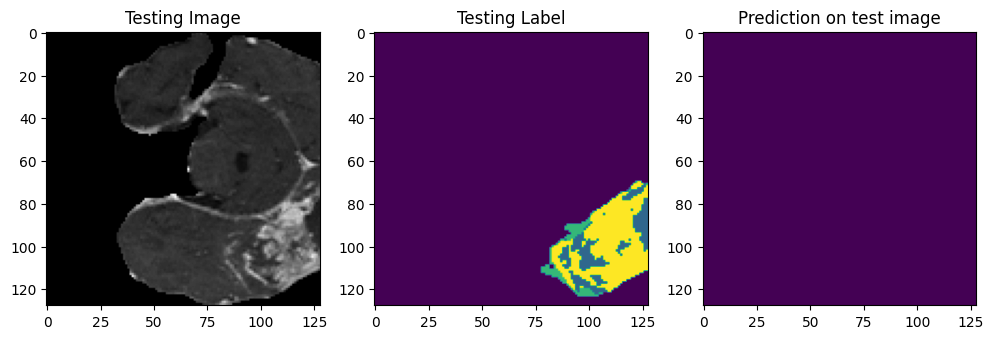

In [31]:
img_num = "0666"
test_img = np.load("split_data/val/input/input_"+img_num+".npz")['arr_0']
test_mask = np.load("split_data/val/output/output_"+img_num+".npz")['arr_0']

test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

n_slice=random.randint(0, test_prediction_argmax.shape[2])
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:,n_slice])
plt.show()

In [32]:
os.getcwd()

'd:\\archive_2021'

In [10]:
import pickle
with open('Trained_models\\fcn3d_trainHistoryDict', 'rb') as file_pi:
    fcn3d = pickle.load(file_pi)

with open('Trained_models\\simple_unet_trainHistoryDict', 'rb') as file_pi:
    simp_unet3d = pickle.load(file_pi)

with open('Trained_models\\attention_unet_3d_trainHistoryDict', 'rb') as file_pi:
    attn_unet3d = pickle.load(file_pi)

with open('Trained_models\\SegNet_3DtrainHistoryDict', 'rb') as file_pi:
    segnet3d = pickle.load(file_pi)

with open('Trained_models\\vnet3d_trainHistoryDict', 'rb') as file_pi:
    vnet3d = pickle.load(file_pi)

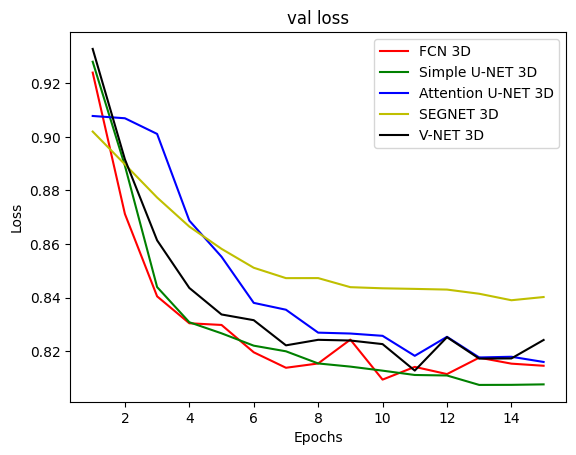

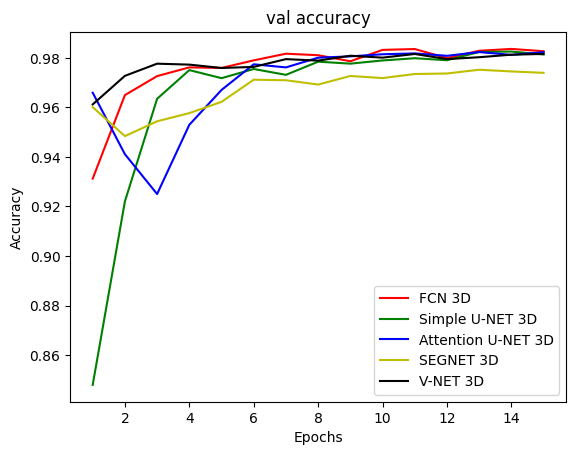

In [11]:
from matplotlib import pyplot as plt

epochs = range(1, len(fcn3d['loss']) + 1)
# plt.figure(dpi=250) 
plt.plot(epochs, fcn3d['val_loss'], 'r', label='FCN 3D')
plt.plot(epochs, simp_unet3d['val_loss'], 'g', label='Simple U-NET 3D')
plt.plot(epochs, attn_unet3d['val_loss'], 'b', label='Attention U-NET 3D')
plt.plot(epochs, segnet3d['val_loss'], 'y', label='SEGNET 3D')
plt.plot(epochs, vnet3d['val_loss'], 'black', label='V-NET 3D')
plt.title('val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plt.figure(dpi=250) 
plt.plot(epochs, fcn3d['val_accuracy'], 'r', label='FCN 3D')
plt.plot(epochs, simp_unet3d['val_accuracy'], 'g', label='Simple U-NET 3D')
plt.plot(epochs, attn_unet3d['val_accuracy'], 'b', label='Attention U-NET 3D')
plt.plot(epochs, segnet3d['val_accuracy'], 'y', label='SEGNET 3D')
plt.plot(epochs, vnet3d['val_accuracy'], 'black', label='V-NET 3D')
plt.title('val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [7]:
import numpy as np
import segmentation_models_3D as sm
from keras.models import load_model
import random
from matplotlib import pyplot as plt



#Define loss, metrics and optimizer to be used for training
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [3]:
fcn3d_model = load_model('Trained_models\\fcn3d.hdf5', 
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})
unet3d_model = load_model('Trained_models\\simple_unet.hdf5', 
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})
attn_unet3d_model = load_model('Trained_models\\attention_unet_3d.hdf5', 
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})
segnet3d_model = load_model('Trained_models\\SegNet_3D.hdf5', 
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})
vnet3d_model = load_model('Trained_models\\vnet3d.hdf5', 
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})

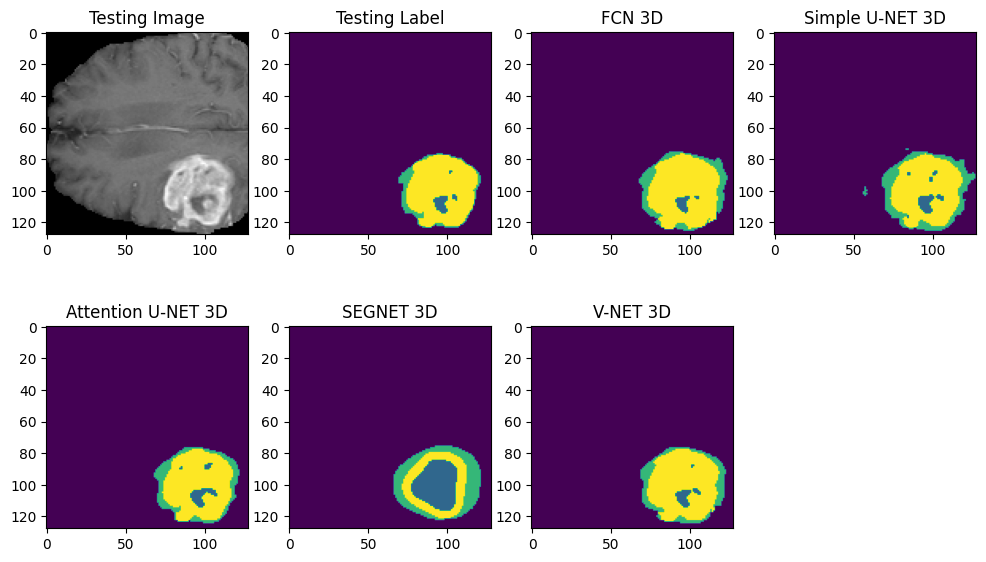

In [8]:
img_num = "0895"
test_img = np.load("split_data/val/input/input_"+img_num+".npz")['arr_0']
test_mask = np.load("split_data/val/output/output_"+img_num+".npz")['arr_0']

test_mask_argmax=np.argmax(test_mask, axis=3)
test_img_input = np.expand_dims(test_img, axis=0)

fcn3d_prediction = fcn3d_model.predict(test_img_input)
unet3d_prediction = unet3d_model.predict(test_img_input)
attn_unet3d_prediction = attn_unet3d_model.predict(test_img_input)
segnet3d_prediction = segnet3d_model.predict(test_img_input)
vnet3d_prediction = vnet3d_model.predict(test_img_input)

fcn3d_prediction_argmax=np.argmax(fcn3d_prediction, axis=4)[0,:,:,:]
unet3d_prediction_argmax=np.argmax(unet3d_prediction, axis=4)[0,:,:,:]
attn_unet3d_prediction_argmax=np.argmax(attn_unet3d_prediction, axis=4)[0,:,:,:]
segnet3d_prediction_argmax=np.argmax(segnet3d_prediction, axis=4)[0,:,:,:]
vnet3d_prediction_argmax=np.argmax(vnet3d_prediction, axis=4)[0,:,:,:]

n_slice=random.randint(0, 127)

plt.figure(figsize=(12, 7))

plt.subplot(241)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')

plt.subplot(242)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])

plt.subplot(243)
plt.title('FCN 3D')
plt.imshow(fcn3d_prediction_argmax[:,:,n_slice])

plt.subplot(244)
plt.title('Simple U-NET 3D')
plt.imshow(unet3d_prediction_argmax[:,:,n_slice])

plt.subplot(245)
plt.title('Attention U-NET 3D')
plt.imshow(attn_unet3d_prediction_argmax[:,:,n_slice])

plt.subplot(246)
plt.title('SEGNET 3D')
plt.imshow(segnet3d_prediction_argmax[:,:,n_slice])

plt.subplot(247)
plt.title('V-NET 3D')
plt.imshow(vnet3d_prediction_argmax[:,:,n_slice])

plt.show()

NameError: name 'fcn3d' is not defined

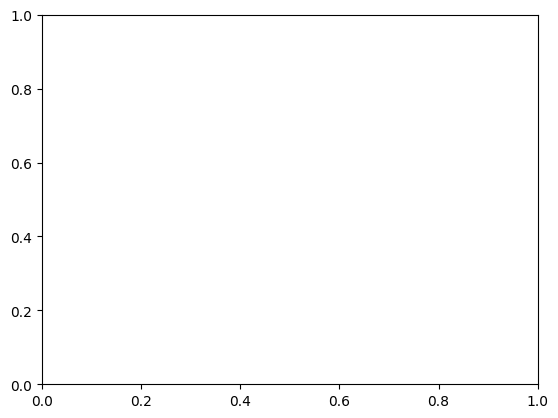

In [9]:
import matplotlib.pyplot as plt
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], round(y[i], 4), ha = 'center')

fig, ax = plt.subplots()
models = ['FCN', 'U-NET', 'Attention U-NET', 'SEGNET', 'V-NET']
counts = [fcn3d['accuracy'][-1], simp_unet3d['accuracy'][-1], attn_unet3d['accuracy'][-1], segnet3d['accuracy'][-1], vnet3d['accuracy'][-1]]
# bar_labels = ['red', 'blue', '_red', 'orange', 'black']
bar_colors = ['red', 'tab:blue', 'tab:green', 'yellow', 'black']

addlabels(models, counts)
ax.bar(models, counts, color=bar_colors)

ax.set_ylabel('Accuracy')
ax.set_xlabel('Architecture')
ax.set_title('Accuracy plot')


plt.ylim(.96, 1)
plt.show()